<a href="https://colab.research.google.com/github/CamelGoong/DataScienceLab/blob/main/%5B%EB%B0%95%ED%95%B4%EA%B7%A0%5D210826_CNN3_%EC%84%B8%EC%85%98%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch 
import torch.nn as nn #많은 neural network이 담겨있는 모듈입니다. 
import torch.optim as optim  # 많은 optimizer가 담겨있는 모듈입니다. 
import torch.nn.init as init # neural network를 초기화 하는 모듈을 담고 있습니다. 
from torch.utils.data import DataLoader # DataLoader는 데이터를 batch_size만큼 불러오는 역할 등을 수행합니다. 
import torchvision 
import torchvision.datasets as dset # 사진 등의 vision 데이터가 담겨있는 모듈입니다. 
import torchvision.transforms as transforms #이 모듈에는 데이터를 자르고, 반전시키고 tensor로 변환해주기 등의 데이터 변환 함수가 담겨있습니다.
import numpy as np
import os 
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
print(torch.__version__)


1.9.0+cu102


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!unzip -qq "/content/gdrive/MyDrive/DSL/20210819_CNN1/archive.zip" -d "/content/gdrive/MyDrive/DSL/20210819_CNN/"

replace /content/gdrive/MyDrive/DSL/20210819_CNN/chest_xray/__MACOSX/._chest_xray? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [47]:
path = '/content/gdrive/MyDrive/DSL/20210819_CNN/chest_xray'
mean = torch.tensor([0.4822])
std = torch.tensor([0.2328])
transformations = transforms.Compose([transforms.Resize((64,64)), 
                              transforms.ToTensor(), 
                              transforms.Normalize(mean, std),
                             ])

In [48]:
train = ImageFolder(os.path.join(path, 'train'), transform=transformations, target_transform=lambda x: np.reshape(np.float32(x),(1)))
val = ImageFolder(os.path.join(path, 'val'), transform=transformations, target_transform=lambda x: np.reshape(np.float32(x),(1)))
test = ImageFolder(os.path.join(path, 'test'), transform=transformations, target_transform=lambda x: np.reshape(np.float32(x),(1)))

In [49]:
print(train.__getitem__(0)[0].size(), train.__len__())
print(test.__getitem__(0)[0].size(), test.__len__())

print(len(train),len(test))
#print(mnist_train[0])


torch.Size([3, 64, 64]) 5216
torch.Size([3, 64, 64]) 624
5216 624


In [82]:
num_epoch=20
batch_size=16
learning_rate= 0.0003

In [52]:
#데이터 쪼개기
train_loader=DataLoader(dataset=train,batch_size=batch_size,shuffle=True,num_workers=3,drop_last=True)
test_loader=DataLoader(dataset=test,batch_size=batch_size,shuffle=False,num_workers=3,drop_last=True)

#1. GoogleNet(CNN)

In [89]:
# 전이학습 모델 import(GoogleNet)
import torchvision.models as models
device=torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
criterion = torch.nn.BCELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate, weight_decay=0.1)

In [90]:
# 1. GoogleNet(CNN)
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.googlenet = models.googlenet(pretrained=True)
        self.FC = nn.Linear(1000,1)
        
    def forward(self,x):
        x = nn.functional.relu(self.googlenet(x))
        x = torch.sigmoid(self.FC(x))
        return x

In [91]:
from torchsummary import summary
model = CNN().to(device)
summary(model, input_size = (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           9,408
       BatchNorm2d-2           [-1, 64, 32, 32]             128
       BasicConv2d-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]           4,096
       BatchNorm2d-6           [-1, 64, 16, 16]             128
       BasicConv2d-7           [-1, 64, 16, 16]               0
            Conv2d-8          [-1, 192, 16, 16]         110,592
       BatchNorm2d-9          [-1, 192, 16, 16]             384
      BasicConv2d-10          [-1, 192, 16, 16]               0
        MaxPool2d-11            [-1, 192, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          12,288
      BatchNorm2d-13             [-1, 64, 8, 8]             128
      BasicConv2d-14             [-1, 6

In [92]:
loss_arr=[]
for i in range(num_epoch):
  for j, [image,label] in enumerate(train_loader):
    x = image.to(device)
    y = label.view(-1,1)
    y = y.to(torch.float32)
    y = y.to(device)
    optimizer.zero_grad()
    prob = model(x)

    loss = criterion(prob, y)
    # loss = loss_func(output, y_)     
    #loss = loss_func(output, torch.max(y_, 1)[1])

    loss.backward()
    optimizer.step()    
    
    if j%1000==0:
      print(loss)
      loss_arr.append(loss.cpu().detach().numpy())

tensor(0.6908, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.8008, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6985, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.8737, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7107, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7296, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5986, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7579, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6744, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7732, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7427, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.8017, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7540, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5317, devic

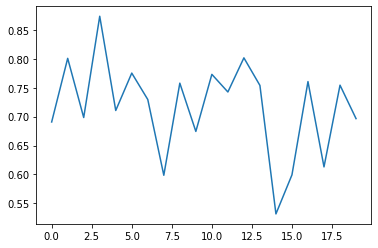

In [93]:
plt.plot(loss_arr)
plt.show()

In [94]:
correct=0
total=0
model.eval()
with torch.no_grad():
  for image,label in test_loader:
    x=image.to(device)
    y_=label.to(device)
    output=model(x)
    pred = output[output.data>0.5]
    correct +=pred.sum()
    total+=label.size(0)

print("Accuracy of Test Data: {}%".format(100*correct/total))

Accuracy of Test Data: 44.359954833984375%


#2. ResNet(CNN2)

In [96]:
# 전이학습 모델 import(ResNet)
import torchvision.models as models
device=torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
criterion = torch.nn.BCELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate, weight_decay=0.1)

In [97]:
# 1. ResNet(CNN2)
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.googlenet = models.resnet101(pretrained=True)
        self.FC = nn.Linear(1000,1)
        
    def forward(self,x):
        x = nn.functional.relu(self.googlenet(x))
        x = torch.sigmoid(self.FC(x))
        return x

In [98]:
from torchsummary import summary
model2 = CNN2().to(device)
summary(model2, input_size = (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           9,408
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]           4,096
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,864
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
           Conv2d-11          [-1, 256, 16, 16]          16,384
      BatchNorm2d-12          [-1, 256, 16, 16]             512
           Conv2d-13          [-1, 256, 16, 16]          16,384
      BatchNorm2d-14          [-1, 256,

In [99]:
loss_arr=[]
for i in range(10):
  for j, [image,label] in enumerate(train_loader):
    x = image.to(device)
    y = label.view(-1,1)
    y = y.to(torch.float32)
    y = y.to(device)
    optimizer.zero_grad()
    prob = model2(x)

    loss = criterion(prob, y)
    # loss = loss_func(output, y_)     
    #loss = loss_func(output, torch.max(y_, 1)[1])

    loss.backward()
    optimizer.step()    
    
    if j%1000==0:
      print(loss)
      loss_arr.append(loss.cpu().detach().numpy())

tensor(0.6635, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5749, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5525, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.3893, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4982, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6918, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6204, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7005, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.8403, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6652, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


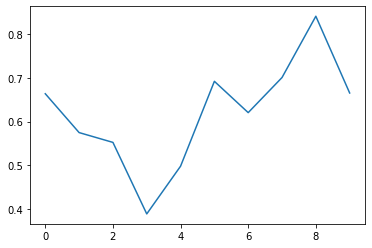

In [100]:
plt.plot(loss_arr)
plt.show()

In [101]:
correct=0
total=0
model2.eval()
with torch.no_grad():
  for image,label in test_loader:
    x=image.to(device)
    y_=label.to(device)
    output=model2(x)
    pred = output[output.data>0.5]
    correct +=pred.sum()
    total+=label.size(0)

print("Accuracy of Test Data: {}%".format(100*correct/total))

Accuracy of Test Data: 65.6050033569336%
